✓ Config Loaded (XGBoost Edition)

=== 1. DATA LOADING ===
🎉 Merged Data: (27323, 28)

=== 2. PREPROCESSING ===
Base Features: ['rain', 'soil', 'temp', 'humi', 'geo', 'rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']

=== 3. FLATTENING (Time Series -> Table) ===
Flattened Input Shape: (12442, 270)
Features per Sample: 270

=== 4. SPLIT & BALANCE ===
Balanced Train Count: Counter({np.int64(0): 5000, np.int64(2): 5000, np.int64(1): 5000})

=== 5. XGBOOST TRAINING ===
[0]	validation_0-mlogloss:0.96175
[1]	validation_0-mlogloss:0.84938
[2]	validation_0-mlogloss:0.75489
[3]	validation_0-mlogloss:0.67415
[4]	validation_0-mlogloss:0.60475
[5]	validation_0-mlogloss:0.54403
[6]	validation_0-mlogloss:0.49055
[7]	validation_0-mlogloss:0.44416
[8]	validation_0-mlogloss:0.40350
[9]	validation_0-mlogloss:0.36723
[10]	validation_0-mlogloss:0.33534
[11]	validation_0-mlogloss:0.30730
[12]	validation_0-mlogloss:0.28232
[13]	validation_0-mlogloss:0.26019
[14]	validation_0-mlogloss:0.24062
[15]	valid

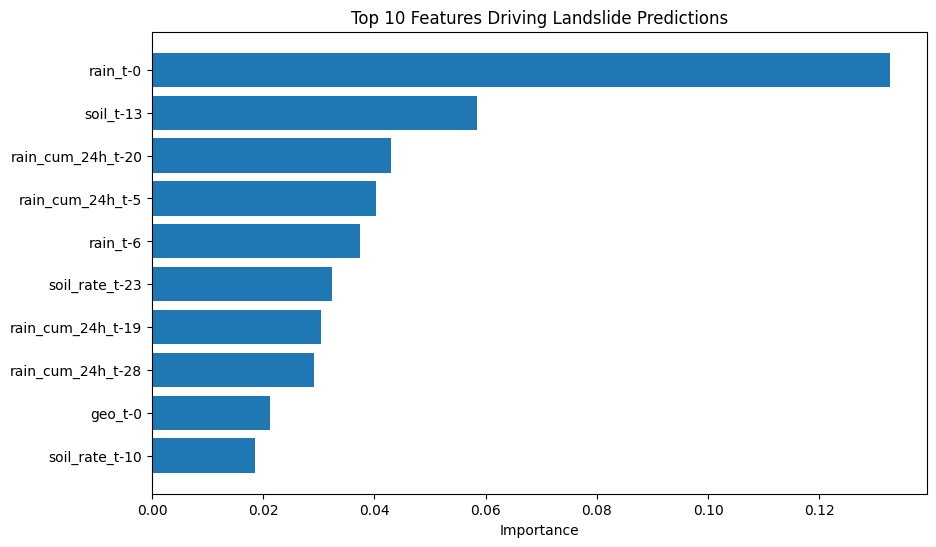

In [3]:
# %%
"""
=========================================================================================
PROJECT: LANDSLIDE DETECTION - XGBOOST EDITION
โครงการ: ระบบตรวจจับดินถล่มด้วย XGBoost (รวมไฟล์อัตโนมัติ + ทำนายแม่นยำ)
=========================================================================================

[WORKFLOW]
1. AUTO-MERGE: รวมไฟล์ CSV ทั้งหมด
2. PREPROCESS: Resample & Physics Features (เหมือนเดิม)
3. FLATTENING: แปลงข้อมูลย้อนหลัง 30 นาที ให้เป็นแถวเดียว (Feature Vector)
4. XGBOOST: เทรนโมเดลด้วย Gradient Boosting Tree
"""

# %%
# ====================================================================
# 1. CONFIGURATION
# ====================================================================
import os
import glob
import re
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

class Config:
    # --- PATHS ---
    DATA_DIR = "./data/" 
    
    # --- OUTPUTS ---
    OUTPUT_MODEL = "landslide_xgboost_model.json" # XGBoost เซฟเป็น JSON หรือ BIN
    OUTPUT_SCALER = "landslide_xgboost_scaler.save"
    
    # --- SETTINGS ---
    SEQUENCE_LENGTH = 30   # ย้อนหลัง 30 นาที
    TEST_SIZE = 0.15
    VAL_SIZE  = 0.15 
    OVERSAMPLE_TARGET = 5000
    
    # XGBoost Hyperparameters
    XGB_PARAMS = {
        'n_estimators': 200,        # จำนวนต้นไม้
        'learning_rate': 0.1,       # อัตราการเรียนรู้
        'max_depth': 6,             # ความลึกของต้นไม้
        'objective': 'multi:softprob', # โจทย์หลายคลาส
        'num_class': 3,             # 3 คลาส (Normal, Warning, Critical)
        'tree_method': 'hist',      # ใช้ Histogram-based (เร็ว)
        'random_state': 42,
        'n_jobs': -1                # ใช้ทุก Core CPU
    }
    
    # Columns
    RAW_COLS = ['rain', 'soil', 'temp', 'humi', 'geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal':0, 'warning':1, 'critical':2}

cfg = Config()
np.random.seed(42); random.seed(42)
print("✓ Config Loaded (XGBoost Edition)")

# %%
# ====================================================================
# 2. DYNAMIC DATA LOADING
# ====================================================================
print("\n=== 1. DATA LOADING ===")

def standardize_columns(df):
    df = df.copy()
    df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
    rename_map = {
        'temperature':'temp', 'hum':'humi', 'humidity':'humi',
        'devid': 'devID', 'deviceid': 'devID', 'device': 'devID', 'node': 'devID',
        'time': 'timestamp', 'date': 'timestamp'
    }
    new_cols = {c: rename_map[c] for c in df.columns if c in rename_map}
    if new_cols: df = df.rename(columns=new_cols)
    
    if 'devID' in df.columns:
        df['devID'] = df['devID'].astype(str).apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    for c in cfg.RAW_COLS:
        if c not in df.columns: df[c] = 0.0
    return df

all_files = glob.glob(os.path.join(cfg.DATA_DIR, "*.csv"))
if not all_files: raise FileNotFoundError("No CSV files found.")

df_list = [standardize_columns(pd.read_csv(f)) for f in all_files]
df_all = pd.concat(df_list, ignore_index=True)
print(f"🎉 Merged Data: {df_all.shape}")

# %%
# ====================================================================
# 3. PREPROCESSING
# ====================================================================
print("\n=== 2. PREPROCESSING ===")

def preprocess_pipeline(df):
    parts = []
    agg_rules = {'rain': 'max', 'soil': 'max', 'geo': 'std', 'temp': 'mean', 'humi': 'mean'}
    for c in cfg.RAW_COLS: 
        if c not in agg_rules: agg_rules[c] = 'mean'

    for dev, g in df.groupby('devID'):
        if g.empty: continue
        g = g.sort_values('timestamp').set_index('timestamp')
        g = g[~g.index.duplicated(keep='first')]
        
        if len(g) > 0: g = g.resample('1T').asfreq()
        g[list(agg_rules.keys())] = g[list(agg_rules.keys())].interpolate(limit_direction='both').fillna(0)
        
        # Physics Features
        g['rain_cum_24h'] = g['rain'].rolling(1440, min_periods=1).sum()
        g['rain_cum_3d']  = g['rain'].rolling(4320, min_periods=1).sum()
        g['soil_rate']    = g['soil'].diff().fillna(0)
        g['geo_abs']      = g['geo'].abs()
        
        if cfg.LABEL_COL in g.columns:
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].fillna('normal').astype(str).str.lower().str.strip()
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].map(cfg.LABEL_MAP).fillna(0).astype(int)
        else:
            g[cfg.LABEL_COL] = 0
            
        g['devID'] = dev
        parts.append(g.reset_index())
        
    return pd.concat(parts, ignore_index=True)

df_proc = preprocess_pipeline(df_all)
FEATURES = cfg.RAW_COLS + ['rain_cum_24h', 'rain_cum_3d', 'soil_rate', 'geo_abs']
print(f"Base Features: {FEATURES}")

# %%
# ====================================================================
# 4. FLATTENING FOR XGBOOST (Important!)
# ====================================================================
print("\n=== 3. FLATTENING (Time Series -> Table) ===")

def create_flattened_dataset(df):
    Xs, ys = [], []
    # Generate feature names for flattened columns (e.g., rain_t-29, rain_t-28...)
    flat_feature_names = []
    for i in range(cfg.SEQUENCE_LENGTH):
        for f in FEATURES:
            flat_feature_names.append(f"{f}_t-{cfg.SEQUENCE_LENGTH-1-i}")
            
    for dev, g in df.groupby('devID'):
        data = g[FEATURES].values
        labels = g[cfg.LABEL_COL].values
        if len(g) < cfg.SEQUENCE_LENGTH: continue
        
        # Sliding Window but Flatten immediately
        for i in range(len(g) - cfg.SEQUENCE_LENGTH + 1):
            # Window shape: (30, 9)
            window = data[i : i+cfg.SEQUENCE_LENGTH]
            # Flatten -> (270,)
            flat_vector = window.flatten()
            
            Xs.append(flat_vector)
            ys.append(labels[i+cfg.SEQUENCE_LENGTH-1])
            
    return np.array(Xs), np.array(ys), flat_feature_names

X_data, y_data, feature_names = create_flattened_dataset(df_proc)
print(f"Flattened Input Shape: {X_data.shape}")
print(f"Features per Sample: {len(feature_names)}")
# ตัวอย่าง: (12442 ตัวอย่าง, 270 ฟีเจอร์)

# %%
# ====================================================================
# 5. SPLIT & BALANCE
# ====================================================================
print("\n=== 4. SPLIT & BALANCE ===")

# 1. Split Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data, y_data, test_size=cfg.TEST_SIZE, stratify=y_data, random_state=42
)

# 2. Split Train/Val
val_ratio = cfg.VAL_SIZE / (1.0 - cfg.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
)

# 3. Oversample Train
def oversample(X, y, target):
    X_res, y_res = [], []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        if len(idx) == 0: continue
        chosen = np.random.choice(idx, target, replace=True)
        X_res.append(X[chosen]); y_res.append(y[chosen])
    X_out = np.concatenate(X_res); y_out = np.concatenate(y_res)
    perm = np.random.permutation(len(X_out))
    return X_out[perm], y_out[perm]

X_train_bal, y_train_bal = oversample(X_train, y_train, cfg.OVERSAMPLE_TARGET)
print(f"Balanced Train Count: {Counter(y_train_bal)}")

# 4. Scale (Optional for XGBoost but good for stability)
scaler = StandardScaler()
scaler.fit(X_train_bal)

X_train_s = scaler.transform(X_train_bal)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, cfg.OUTPUT_SCALER)

# %%
# ====================================================================
# 6. XGBOOST TRAINING
# ====================================================================
print("\n=== 5. XGBOOST TRAINING ===")

# Initialize Model
model = XGBClassifier(**cfg.XGB_PARAMS)

# Train
model.fit(
    X_train_s, y_train_bal,
    eval_set=[(X_val_s, y_val)],
    verbose=True
)

# Save Model
model.save_model(cfg.OUTPUT_MODEL)
print("\n✓ XGBoost Model Saved.")

# %%
# ====================================================================
# 7. EVALUATION & FEATURE IMPORTANCE
# ====================================================================
print("\n=== 6. EVALUATION ===")

def evaluate_xgb(name, X, y_true):
    print(f"\n>>> {name} RESULTS <<<")
    y_pred = model.predict(X)
    
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Warning', 'Critical']))

evaluate_xgb("VALIDATION SET", X_val_s, y_val)
evaluate_xgb("TEST SET", X_test_s, y_test)

# --- Feature Importance (Bonus) ---
# ดูว่า XGBoost ให้ความสำคัญกับฟีเจอร์ไหนมากที่สุด (เช่น ฝนสะสม หรือ ความชื้น)
print("\n=== TOP 10 IMPORTANT FEATURES ===")
importance = model.feature_importances_
# Map importance back to names
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(10)
print(feat_imp)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Features Driving Landslide Predictions')
plt.gca().invert_yaxis()
plt.show()